In [108]:
#pip install imbalanced-learn
#pip install delayed

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# please read the csv directly for next step
df = pd.read_csv('telco_with_polarity.csv')

In [3]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,Polarity
0,0,71,90.35,0,1,0,1,0,1,0,...,0,1,1,0,0,0,1,0,No,0.166667
1,0,54,69.95,1,0,0,1,0,1,0,...,0,1,1,0,1,0,0,0,No,0.089899
2,0,71,24.55,1,0,1,0,1,0,0,...,0,1,1,0,0,0,1,0,No,0.650000
3,0,1,50.05,0,1,1,0,0,1,0,...,0,0,0,1,0,0,1,0,No,0.000000
4,0,11,74.55,0,1,1,0,1,0,0,...,0,0,0,1,0,0,1,0,Yes,0.000000


In [4]:
x = df.drop('Churn',axis=1)

In [5]:
y = df[['Churn']]

In [6]:
SEED = 4
(X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=0.3, stratify=y, random_state=SEED)

### Step 1: Resample Imbalanced Training Data Using Smote and Oversampling (Hybrid)

In [7]:
y_train[y_train['Churn']=='No'].shape

(3622, 1)

In [8]:
y_train[y_train['Churn']=='Yes'].shape

(1308, 1)

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.6) # First oversample Yes to be 60% of the original No
under = RandomUnderSampler(sampling_strategy=0.8) # Then undersample No so that Yes:No ration is 4:5

steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

In [10]:
X_train,y_train = pipeline.fit_resample(X_train,y_train)

In [11]:
y_train[y_train['Churn']=='No'].shape

(2716, 1)

In [12]:
y_train[y_train['Churn']=='Yes'].shape

(2173, 1)

### Step 2: Run Various Model to Test Accuracy and F1 scores

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as MSE

### Model 1: Random Forest
- We first use grid search to find the optimal parameters for n_estimators, max_depth, and min_samples_leaf

In [40]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None,min_samples_leaf=1)

In [41]:
param_grid = {
                 'n_estimators': [200,400,600,800],
                 'max_depth': [5,7,10,None],
                'min_samples_leaf': [1,2,3,4,5]
             }
grid_clf = GridSearchCV(rf, param_grid, cv=10,n_jobs=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_estimators=200),
             n_jobs=10,
             param_grid={'max_depth': [5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [200, 400, 600, 800]})

In [42]:
grid_clf.best_estimator_

RandomForestClassifier(min_samples_leaf=3, n_estimators=600)

In [43]:
rf = RandomForestClassifier(n_estimators=600, max_depth=None,min_samples_leaf=3, random_state=SEED)

In [44]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

          No       0.87      0.83      0.85      1552
         Yes       0.58      0.64      0.61       561

    accuracy                           0.78      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.78      0.79      2113



In [46]:
rf_metric = [metrics.accuracy_score(y_test, y_pred_rf),metrics.precision_score(y_test, y_pred_rf,pos_label='Yes'),
        metrics.recall_score(y_test, y_pred_rf,pos_label='Yes'),metrics.f1_score(y_test, y_pred_rf,pos_label='Yes')]

Text(0.5, 257.44, 'Predicted label')

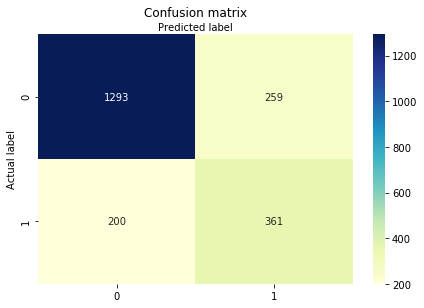

In [57]:
cnf_matrix_rf = metrics.confusion_matrix(y_test, y_pred_rf)
cnf_matrix_rf

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_rf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model 2: K-Nearest Neighbors
- We first use grid search to find the optimal parameters for n_neighbors

In [47]:
knn = KNeighborsClassifier(n_neighbors=4)

In [50]:
param_grid = {'n_neighbors': [3,5,7,9]}
grid_clf = GridSearchCV(knn, param_grid, cv=10,n_jobs=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=4), n_jobs=10,
             param_grid={'n_neighbors': [3, 5, 7, 9]})

In [51]:
grid_clf.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [52]:
knn = KNeighborsClassifier(n_neighbors=3)

In [53]:
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

          No       0.86      0.75      0.80      1552
         Yes       0.49      0.65      0.56       561

    accuracy                           0.73      2113
   macro avg       0.67      0.70      0.68      2113
weighted avg       0.76      0.73      0.74      2113



In [55]:
knn_metric = [metrics.accuracy_score(y_test, y_pred_knn),metrics.precision_score(y_test, y_pred_knn,pos_label='Yes'),
        metrics.recall_score(y_test, y_pred_knn,pos_label='Yes'),metrics.f1_score(y_test, y_pred_knn,pos_label='Yes')]

Text(0.5, 257.44, 'Predicted label')

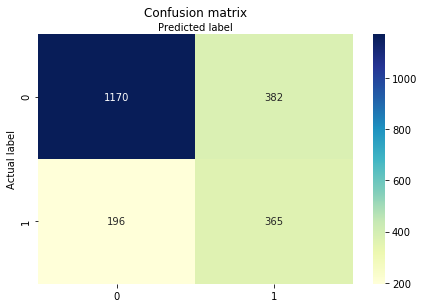

In [56]:
cnf_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)
cnf_matrix_knn

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_knn), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model 3: Logistic Regression

In [58]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

          No       0.87      0.84      0.86      1552
         Yes       0.60      0.65      0.62       561

    accuracy                           0.79      2113
   macro avg       0.73      0.74      0.74      2113
weighted avg       0.80      0.79      0.79      2113



In [60]:
logit_metric = [metrics.accuracy_score(y_test, y_pred_lr),metrics.precision_score(y_test, y_pred_lr,pos_label='Yes'),
        metrics.recall_score(y_test, y_pred_lr,pos_label='Yes'),metrics.f1_score(y_test, y_pred_lr,pos_label='Yes')]

Text(0.5, 257.44, 'Predicted label')

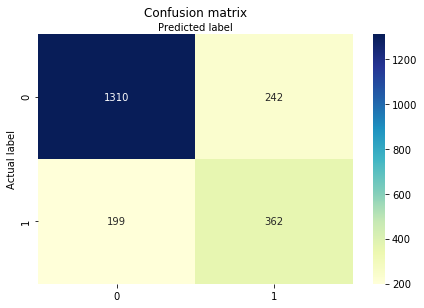

In [61]:
cnf_matrix_lr = metrics.confusion_matrix(y_test, y_pred_lr)
cnf_matrix_lr

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model 4: Support Vector Machine

In [62]:
svm = svm.SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

          No       0.87      0.79      0.83      1552
         Yes       0.54      0.67      0.59       561

    accuracy                           0.76      2113
   macro avg       0.70      0.73      0.71      2113
weighted avg       0.78      0.76      0.77      2113



In [64]:
svm_metric = [metrics.accuracy_score(y_test, y_pred_svm),metrics.precision_score(y_test, y_pred_svm,pos_label='Yes'),
        metrics.recall_score(y_test, y_pred_svm,pos_label='Yes'),metrics.f1_score(y_test, y_pred_svm,pos_label='Yes')]

Text(0.5, 257.44, 'Predicted label')

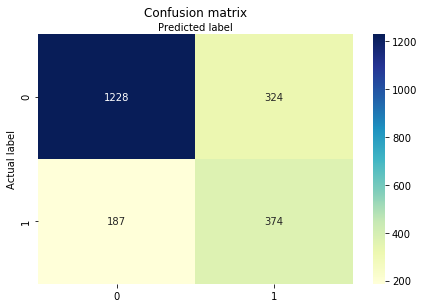

In [65]:
cnf_matrix_svm = metrics.confusion_matrix(y_test, y_pred_svm)
cnf_matrix_svm

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_svm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model 5: Decision Tree
- We first use grid search to find optimal parameters for max_depth and min_samples_split

In [72]:
dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state = SEED)

In [73]:
param_grid = {
                 'max_depth': [5,7,10,None],
                'min_samples_split': [1,2,3,4,5]
             }
grid_clf = GridSearchCV(dt, param_grid, cv=10,n_jobs=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4), n_jobs=10,
             param_grid={'max_depth': [5, 7, 10, None],
                         'min_samples_split': [1, 2, 3, 4, 5]})

In [74]:
grid_clf.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_split=3, random_state=4)

In [75]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_split=3, random_state = SEED)

In [76]:
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test) 

In [77]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

          No       0.87      0.79      0.83      1552
         Yes       0.54      0.67      0.60       561

    accuracy                           0.76      2113
   macro avg       0.70      0.73      0.71      2113
weighted avg       0.78      0.76      0.77      2113



In [78]:
dt_metric = [metrics.accuracy_score(y_test, y_pred_dt),metrics.precision_score(y_test, y_pred_dt,pos_label='Yes'),
        metrics.recall_score(y_test, y_pred_dt,pos_label='Yes'),metrics.f1_score(y_test, y_pred_dt,pos_label='Yes')]

Text(0.5, 257.44, 'Predicted label')

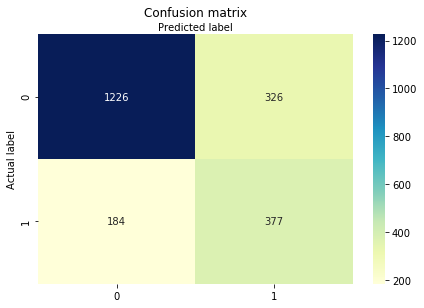

In [79]:
cnf_matrix_dt = metrics.confusion_matrix(y_test, y_pred_dt)
cnf_matrix_dt

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_dt), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Step 3: Summary

In [81]:
res = pd.DataFrame([rf_metric, knn_metric, logit_metric, svm_metric, dt_metric],
                   columns = ['Accuracy','Precision','Recall','F-1'], 
                   index = ['RandomForest','KNN','Logit','SVM','DecisionTree'])
res = res.sort_values(by=['F-1'],ascending=False)
res          # sort by f-1 score

,Accuracy,Precision,Recall,F-1
Logit,0.791292,0.599338,0.645276,0.621459
RandomForest,0.782773,0.582258,0.643494,0.611346
DecisionTree,0.758637,0.536273,0.672014,0.596519
SVM,0.758164,0.535817,0.666667,0.594122
KNN,0.726455,0.488621,0.650624,0.558104


Text(0, 0.5, 'F-1 Score')

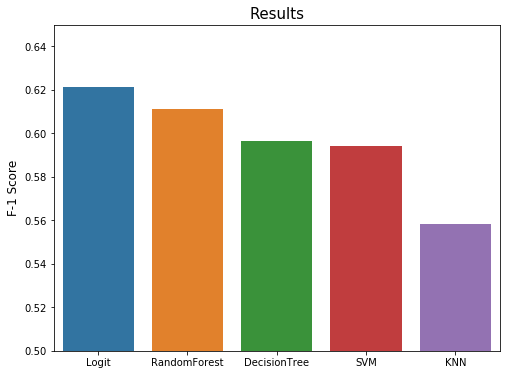

In [85]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=res.index,
                 y="F-1", data = res)

ax.set_ylim(0.5,0.65)
ax.set_title('Results',size = 15)
ax.set_ylabel('F-1 Score',size = 12)

### Analysis of Feature Importance

### 1. Feature Importance from Decision Tree

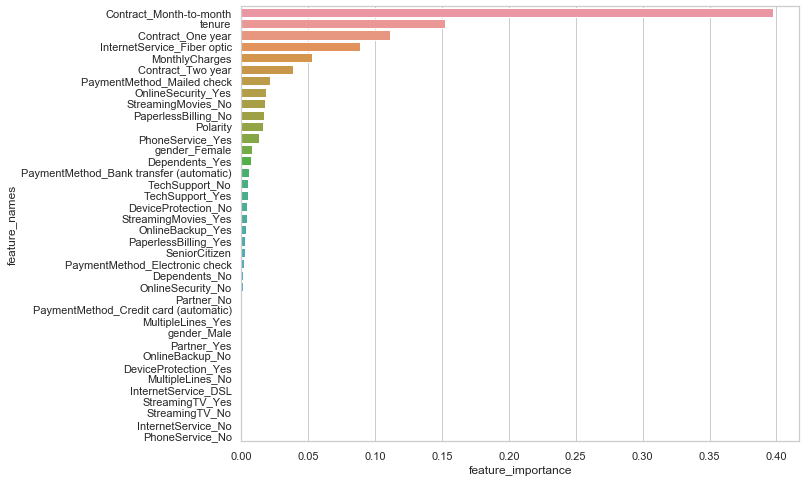

In [96]:
sns.set_theme(style="whitegrid")

dt_feature ={'feature_names':X_train.columns,'feature_importance':dt.feature_importances_}

dt_df = pd.DataFrame(dt_feature)

dt_df.sort_values(by='feature_importance',ascending=False,inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=dt_df.feature_importance, y=dt_df.feature_names)

### 2. Feature Importance from Random Forrest

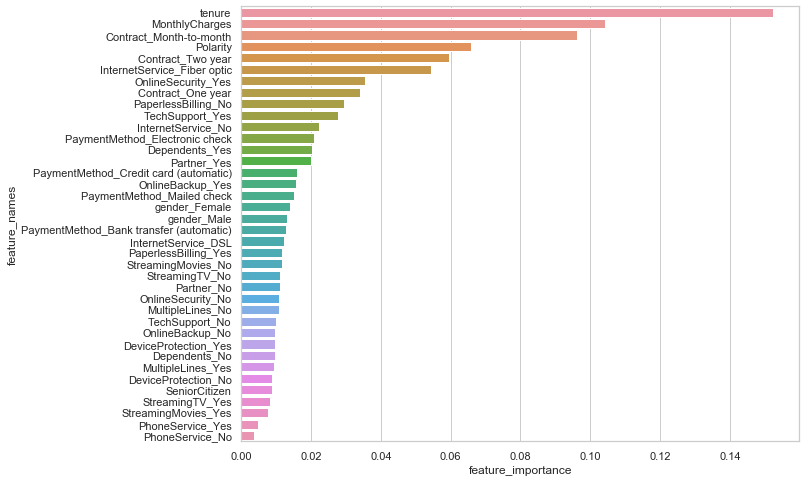

In [95]:
sns.set_theme(style="whitegrid")
rf_feature ={'feature_names':X_train.columns,'feature_importance':rf.feature_importances_}

rf_df = pd.DataFrame(rf_feature)

rf_df.sort_values(by='feature_importance',ascending=False,inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=rf_df.feature_importance, y=rf_df.feature_names)

### 3. Coefficients from Logsitic Regression

In [106]:
lr.coef_[0]

array([ 0.27337773, -0.03395263,  0.11250905, -1.86589418, -1.82850899,
       -1.2947087 , -1.39428   , -0.91584912, -1.25837982,  2.13539536,
       -0.42465008, -0.14704397, -0.55992942,  0.36337259, -1.40848148,
        2.60092035, -0.3183693 , -1.27252746, -0.41172411, -1.15701176,
       -0.56099588, -1.09380196,  0.04731984, -0.91953324,  0.30616915,
       -0.57061131,  0.34261454, -0.50259081,  0.02322855, -0.6765593 ,
       -1.73086342, -1.17024365, -0.87103385, -1.8839648 , -1.97674708,
       -1.46463789, -1.95244876,  0.42307175])

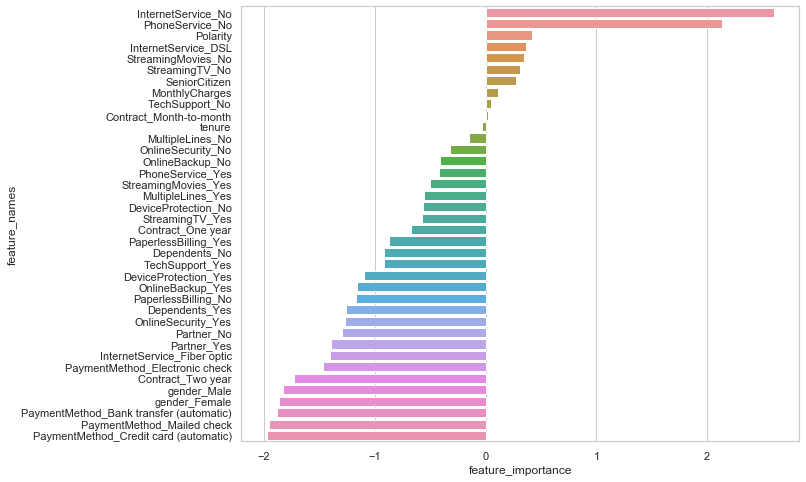

In [107]:
sns.set_theme(style="whitegrid")
lr_feature ={'feature_names':X_train.columns,'feature_importance':lr.coef_[0]}

lr_df = pd.DataFrame(lr_feature)

lr_df.sort_values(by='feature_importance',ascending=False,inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=lr_df.feature_importance, y=lr_df.feature_names)